## Resolving the Boat structure

Here I'm going to try to cluster the images based on boat, automatically. This can be useful for us in a variety of ways, for example it would allow us to create a separate model for each boat, or mask out which parts of the boat can't contain fish in order to help our classifier detect the fish.

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn import cluster
from scipy.misc import imread
from tqdm import tqdm_notebook as tq
import cv2
import skimage.measure as sm
# import progressbar
import multiprocessing
import random
import matplotlib.pyplot as plt
import os
import pickle
from shutil import copyfile
#import seaborn as sns
%matplotlib inline
new_style = {'grid': False}
plt.rc('axes', **new_style)

# Function to show 4 images
def show_four(imgs, title):
    #select_imgs = [np.random.choice(imgs) for _ in range(4)]
    select_imgs = [imgs[np.random.choice(len(imgs))] for _ in range(4)]
    _, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(20, 3))
    plt.suptitle(title, size=20)
    for i, img in enumerate(select_imgs):
        ax[i].imshow(img)

# Function to show 8 images
def show_eight(imgs, title):
    select_imgs = [imgs[np.random.choice(len(imgs))] for _ in range(32)]
    _, ax = plt.subplots(32, 4, sharex='col', sharey='row', figsize=(20, 6))
    plt.suptitle(title, size=20)
    for i, img in enumerate(select_imgs):
        ax[i // 4, i % 4].imshow(img)

In [2]:
a = glob.glob('./train/*/*.jpg')
with open("boats_ids.p", "wb") as f:
    pickle.dump(a,f)

In [2]:
select = 300 # Only load 500 images for speed
# Data loading
print("img left: " + str(len(sorted(glob.glob('./boats_ids/*/*.jpg'), key=lambda x: random.random()))))
train_files = sorted(glob.glob('./boats_ids/*/*.jpg'), key=lambda x: random.random())
train = np.array([imread(img) for img in train_files])
print('Length of train {}'.format(len(train)))

img left: 728
Length of train 728


### Image Size

The images in the training set are not all the same size, but rather there are a few distinct image sizes that we have to work with. Maybe there are some image sizes which only contain a single boat? Let's try treating the image sizes as BoatIDs and check!

In [3]:
print('Sizes in train:')
shapes = np.array([str(img.shape) for img in train])
pd.Series(shapes).value_counts()

Sizes in train:


(750, 1280, 3)    421
(974, 1280, 3)    102
(720, 1280, 3)     88
(670, 1192, 3)     34
(750, 1334, 3)     26
(718, 1276, 3)     22
(700, 1244, 3)     16
(974, 1732, 3)     11
(854, 1518, 3)      8
dtype: int64

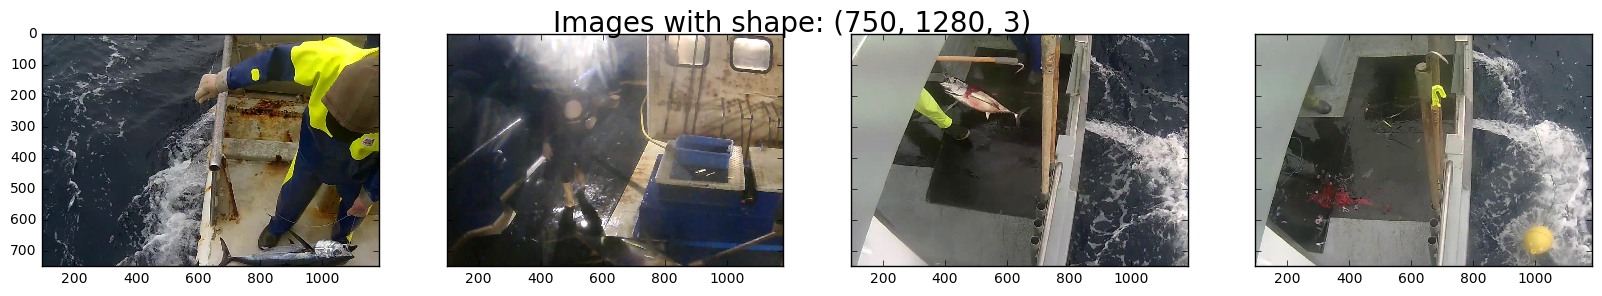

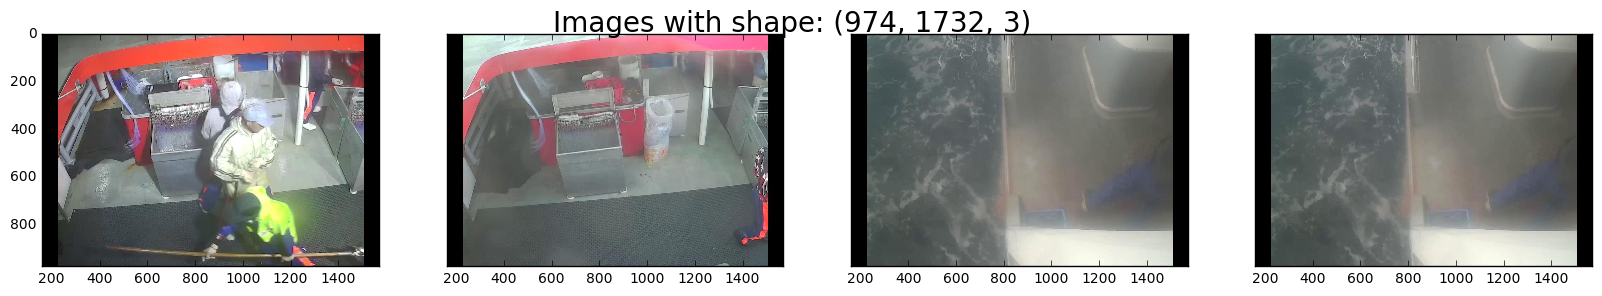

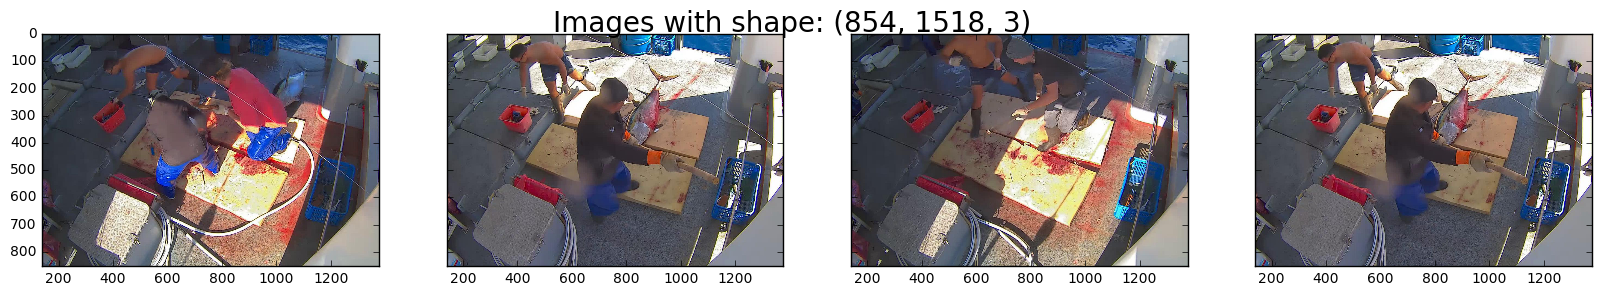

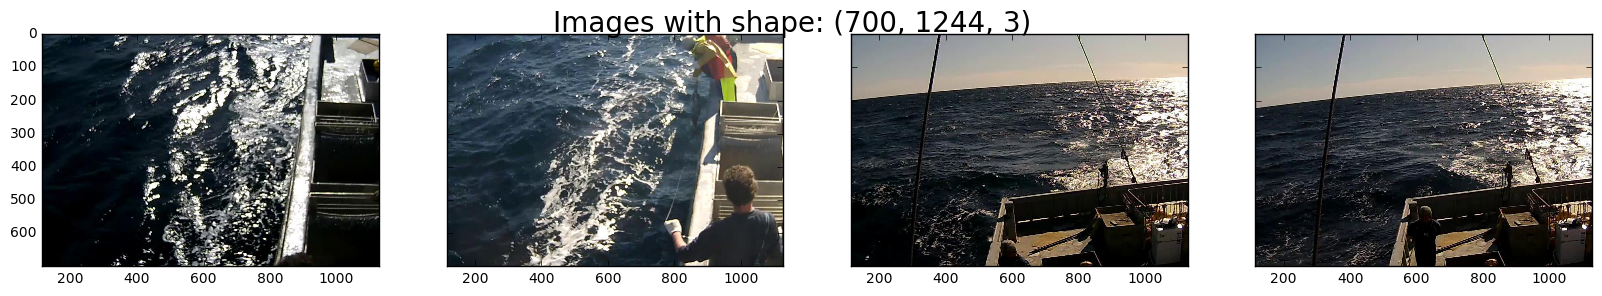

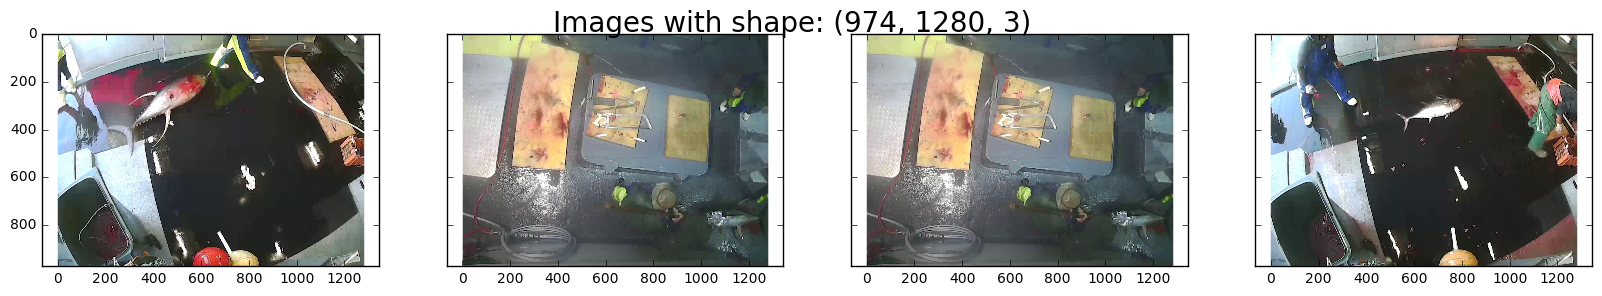

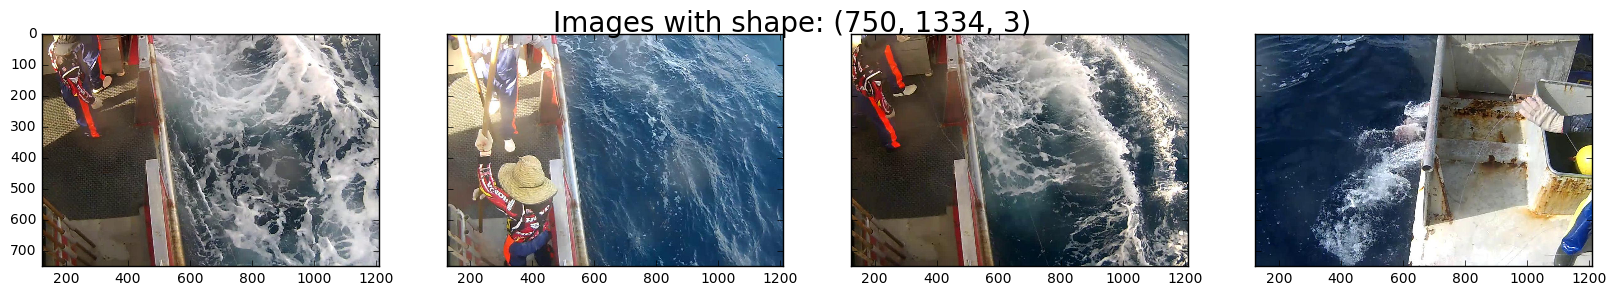

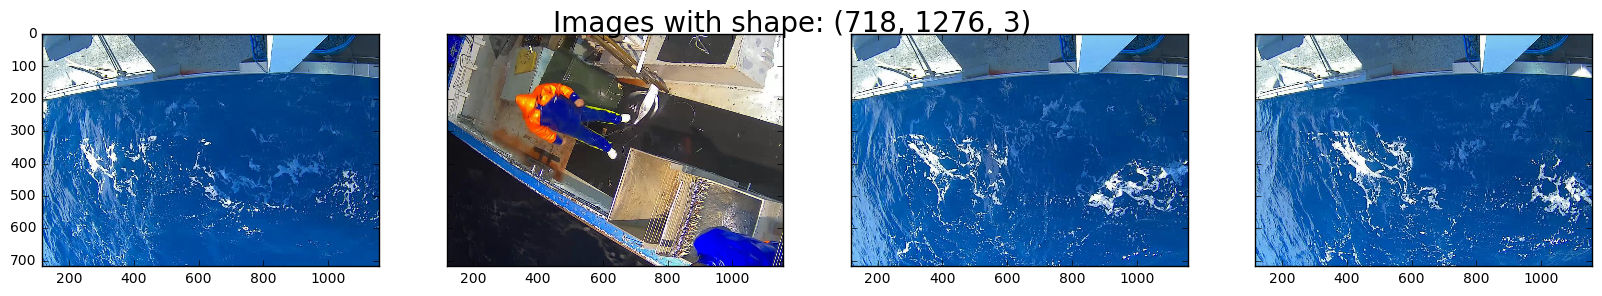

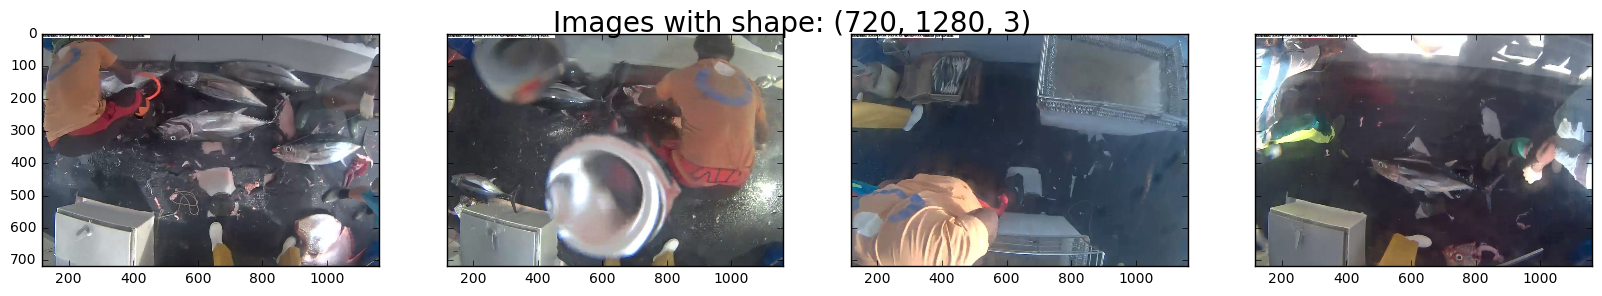

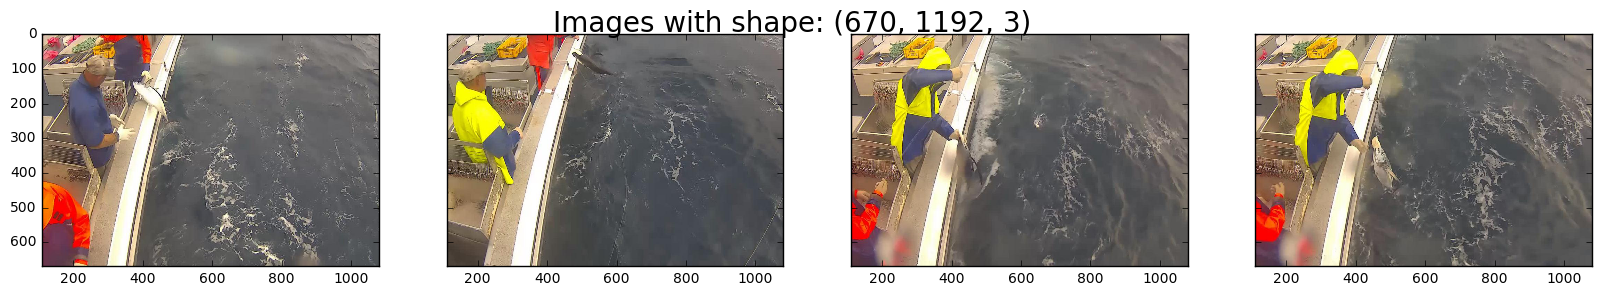

In [4]:
for uniq in pd.Series(shapes).unique():
    show_four(train[shapes == uniq], 'Images with shape: {}'.format(uniq))
    plt.show()

Here we can see that, with the exception of (854, 1518, 3), all the other image sizes all contain more than one boat. It looks like while this may be helpful, we need to take another approach to truly separate the boats.

## Boat Clustering

Here I'm just going to work on just these 500 loaded images for speed, but there's nothing stopping you from doing exactly the same thing with all the images.

My approach has three steps:
- Normalise all the images by subtracting the mean (of that image) and dividing by the stdev.
- Treat the mean absolute pixel error between the images as the distance between the image.
- Use this to create a precomputed distance matrix, and then pass the points to DBSCAN to create the boat clusters.

In [5]:
# Function for computing distance between images
import os
import pickle
def compare(img, img2):
    #img = (img - img.mean()) / img.std()
    #img2 = (img2 - img2.mean()) / img2.std()
    return np.mean(np.abs(img - img2))

# Resize the images to speed it up.
train = [cv2.resize(img, (224, 224), cv2.INTER_LINEAR) for img in train]

custom_train = []
for img in tq(train):
    im = (img - img.mean()) / img.std()
    custom_train.append(im.reshape((224*224*3,)))
    
train = np.array(custom_train)

l = len(train)

list_distances = []

for i in tq(range(len(train))):
    #path = "./distances/distances_" + str(i)
    line_distances = []
    for j in range(len(train)):
        line_distances.append(compare(train[i], train[j]))
    
    list_distances.append(line_distances)

distances = np.array(list_distances)

Now I have a NxN matrix where N is the number of images, denoting the distances between the images.

Some clustering algorithms in SKLearn allow you to use a precomputed distance matrix instead of letting the algorithm compute it, which is very useful in cases like here where you can work out the distance between points but you can't give each image coordinates. Here I'll be using the DBSCAN algorithm.

Let's take a peek at our distance matrix:

[[ 0.          1.2973844   1.22743113 ...,  0.73278486  1.22211712
   1.24011241]
 [ 1.2973844   0.          1.10746368 ...,  1.29882805  1.11553901
   0.79138557]
 [ 1.22743113  1.10746368  0.         ...,  1.21560459  1.0736376
   1.09570656]
 ..., 
 [ 0.73278486  1.29882805  1.21560459 ...,  0.          1.27605462
   1.24704656]
 [ 1.22211712  1.11553901  1.0736376  ...,  1.27605462  0.          1.1106714 ]
 [ 1.24011241  0.79138557  1.09570656 ...,  1.24704656  1.1106714   0.        ]]



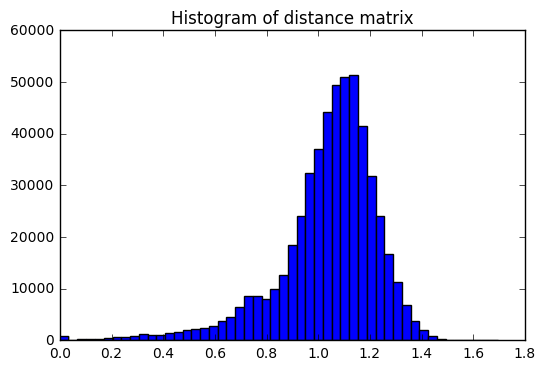

In [6]:
print(distances)
plt.hist(distances.flatten(), bins=50)
plt.title('Histogram of distance matrix')
print('')

We can see here that we have an area below 0.8. My hypothesis is that this is the area where two images are of the same boat. By default, DBSCAN considers up to a 0.5 distance to be in the same cluster. I tweaked the parameters and found that 0.6 is the best value, which makes reasonable sense looking at the histogram.

In [7]:
distances = np.array(list_distances)
cls = cluster.DBSCAN(metric='precomputed', min_samples=5, eps=0.6)
y = cls.fit_predict(distances)
print(y)
print('Cluster sizes:')
print(pd.Series(y).value_counts())

[ 0  1  2  0  0  0 -1  3  0 -1  0  4  5  0  6 -1  0  0  7  8  0  0  0  0  9
  0 10  0  0  0 -1  0  4 -1 -1  9  0 11  3  0  0 -1 -1 12  0  0  4  0 13  9
  0  0  0  0 14  0 15  0 16  0 -1  1 24 12 -1 -1  9 -1  0  9  0  0  0 -1  0
  0 17 -1  0  0  9 19 11 -1 -1  0 -1 -1  7 -1  0  0  0  0 22  0  0  7 18  0
  0  0  0 -1 19 -1  0  0  0  0  9  0  0  0  0 20 11  9 -1 -1  3 -1  0 22  0
 -1  4 -1  4  0  0  0 -1  9  8  0  0 20  0  0  0  0 -1  0  8  0  0  0  7  0
  0  3  0  5  8  0  0  9  0  0 -1  0  0 -1 -1  2 -1 -1  0  0  7  0 16  0 -1
 -1  0 -1  0  0  0  4  0  0  0  0  0  1  1  0  0  0 21 -1  9  0  0  0  9 -1
  9  0  0  0 -1  0 22 14 21 -1 -1  0  8 14  0 -1 21  4  0 23 24  4 -1 -1  0
  0  0 -1 -1 -1  0 -1  0 -1 10  0  0 -1  0  9 11 -1  0  4 -1  0  0  0  9 23
 21  0  0 -1  0  0  7  0 21 23 -1 18  0 -1  0 -1  0  0 11 11  0  7 10 -1  7
  0  0  0 -1  0 -1  0  0  0  0 -1  9 -1  0 23 -1 -1 -1  0 17  0 -1  1 -1  0
  0  0  0 -1  7  0  0 10  0 -1 -1  0  0  9 -1 12 -1  0  0 12 14 -1 -1  4  5
  0 -1  0 16

In [8]:
for i in range(-1,40):
    try:
        os.makedirs("new_boats - Copy-2/" + str(i))
    except:
        pass

In [9]:
from shutil import copyfile
for i in range(len(train_files)):
    try:
        copyfile(train_files[i], "./new_boats - Copy-2/" + str(y[i]) + "/" + train_files[i].split("\\")[-1])
        os.remove(train_files[i])
    except:
        pass

TypeError: Invalid dimensions for image data

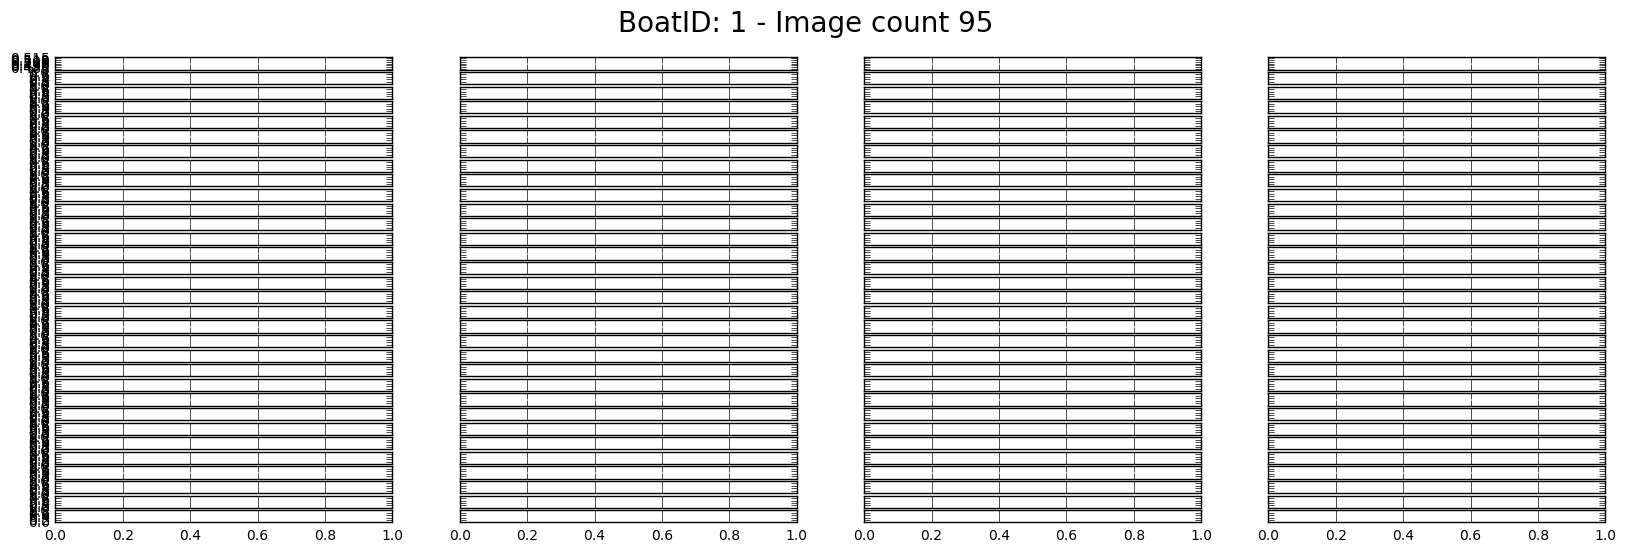

In [9]:
for uniq in pd.Series(y).value_counts().index:
    if uniq != -1:
        size = len(np.array(train)[y == uniq])
        if size > 10:
            show_eight(np.array(train)[y == uniq], 'BoatID: {} - Image count {}'.format(uniq, size))
            plt.show()
        else:
            show_four(np.array(train)[y == uniq], 'BoatID: {} - Image count {}'.format(uniq, size))
            plt.show()            

This is working surprisingly well!

However, we have a bunch of images that haven't been clustered into any BoatID. There are two possible reasons for these:
1. There are less than 5 images from the boat, which I have set as the threshold for a boatID.
2. The distance function is not good enough to cluster the images (eg. some images may be in the night vs the day - this would break my algorithm.)

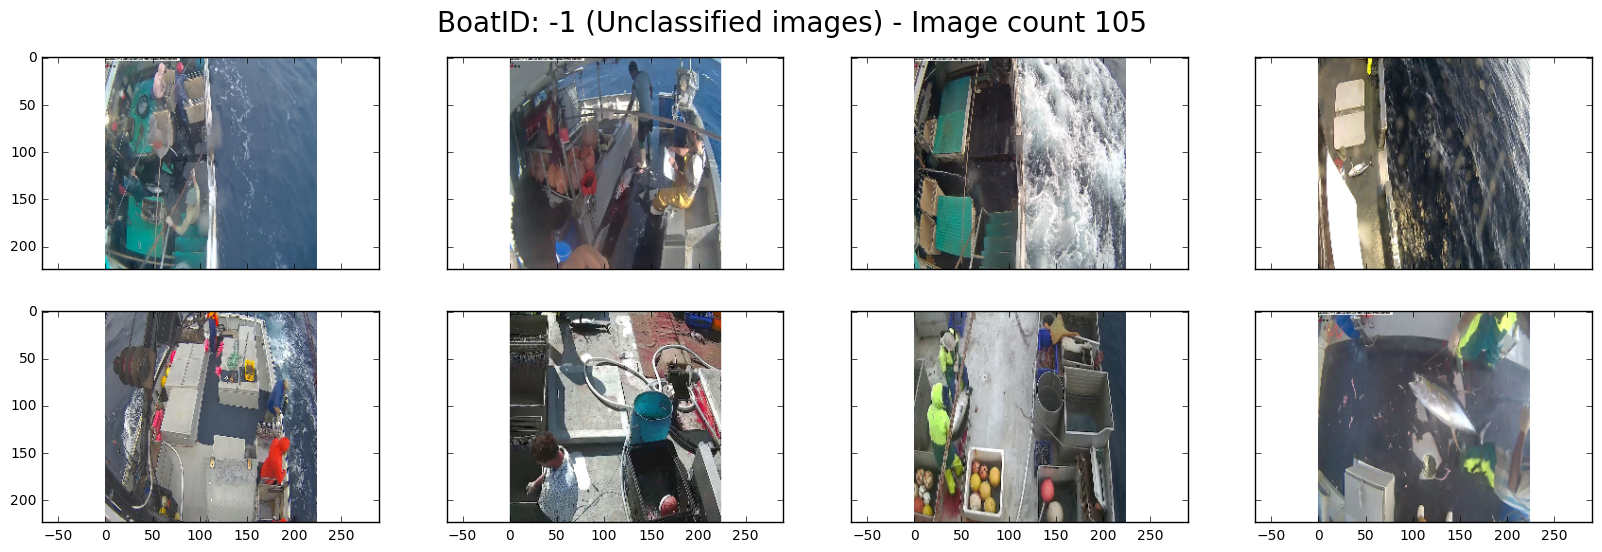

In [9]:
size = len(np.array(train)[y == -1])
show_eight(np.array(train)[y == -1], 'BoatID: {} (Unclassified images) - Image count {}'.format(-1, size))

Some of these I can cluster by eye, so it looks like the algorithm needs some tweaking to be able to cluster every image!

However, I think this can be considered a sucess as I've managed to cluster the boats very precisely, while clustering >75% of the boats. Since this is unsupervised, it can be run on the test set to in order to understand which boat is which!

Any feedback is very much appreciated, along with any upvotes for motivation ;)

Good luck!